# Satellite Derived Bathymetry
## Import modules/libraries

Import `Rasterio` and `GeoPandas` as GeoTIFF and ESRI Shapefile reader.

In [1]:
import geopandas as gpd
import rasterio as rio

Import `Numpy` and `ndimage` from `Scipy`.

In [2]:
import numpy as np
import pandas as pd
from scipy import ndimage

Import machine learning tools from `Scikit Learn`.

In [3]:
from joblib import parallel_backend
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

Import `os` module for file path related function

In [4]:
import os

Import `pyplot` from `matpplotlib` to generate scatter plot from the results

In [5]:
import matplotlib.pyplot as plt

## Initiate variables consist of file locations and processing settings

Insert input and output file locations.

In [6]:
img_loc = 'data/image.tif'
new_img_loc = 'data/depth_prediction.tif'
shp_loc = 'data/depth_sample.shp'

Input file values and processing settings and using negative sign in depth values.

In [7]:
depth_col_name = 'Z_Koreksi' # depth column name of shapefile sample data
depth_limit_a = 0 # depth upper limit
depth_limit_b = -15 # depth bottom limit 
train_size = 0.75 # 75% train size
random_state= 2
val_if_nan = -999.0
n_tree = 300 # number of tree in Random Forest
n_jobs = -2 # number of core processing. -2 means that it will use all core except 2
median_filter_size = 3 # median filter cell size (use odd number)

## Open image data and depth samples

Open image using `Rasterio`, showing its arrays and Coordinate Reference System (CRS).

In [8]:
img = rio.open(img_loc)
print('img size\n', img.shape, '\n\n', img.crs)

img size
 (192, 344) 

 EPSG:32748


Rearrange image array into n column array based on number of bands.

In [9]:
nbands = len(img.indexes)
ndata = img.read(1).size
bands_dummy = np.empty((nbands, ndata))

for i in img.indexes:
    bands_dummy[i - 1, :] = np.ravel(img.read(i))

bands_array = bands_dummy.T
print('bands_array size\n', bands_array.shape)

bands_array size
 (66048, 4)


Opening depth sample using Geopandas.

In [10]:
shp = gpd.read_file(shp_loc)
shp

,X,Y,Z_Koreksi,geometry
0,673089.824,9371020.537,10.644119,POINT Z (673089.824 9371020.537 10.644)
1,673090.677,9371020.627,10.654119,POINT Z (673090.677 9371020.627 10.654)
2,673088.900,9371020.741,10.684119,POINT Z (673088.900 9371020.741 10.684)
3,673091.478,9371020.835,10.314119,POINT Z (673091.478 9371020.835 10.314)
4,673092.281,9371021.078,8.904119,POINT Z (673092.281 9371021.078 8.904)
...,...,...,...,...
4629,673371.323,9371449.837,1.806161,POINT Z (673371.323 9371449.837 1.806)
4630,673368.173,9371449.948,1.606161,POINT Z (673368.173 9371449.948 1.606)
4631,673370.582,9371450.079,1.766161,POINT Z (673370.582 9371450.079 1.766)
4632,673368.959,9371450.110,1.666161,POINT Z (673368.959 9371450.110 1.666)


## Prepare input data until depth prediction using `Scikit Learn`

Check if both image and depth sample have the same CRS. If both have different CRS, reproject depth sample CRS to match image CRS.

In [11]:
img_crs = str(img.crs).upper()
shp_crs = str(shp.crs).upper()

if img_crs != shp_crs:
    shp_reproj = shp.to_crs(img_crs)
else:
    shp_reproj = shp.copy()

shp_reproj

,X,Y,Z_Koreksi,geometry
0,673089.824,9371020.537,10.644119,POINT Z (673089.824 9371020.537 10.644)
1,673090.677,9371020.627,10.654119,POINT Z (673090.677 9371020.627 10.654)
2,673088.900,9371020.741,10.684119,POINT Z (673088.900 9371020.741 10.684)
3,673091.478,9371020.835,10.314119,POINT Z (673091.478 9371020.835 10.314)
4,673092.281,9371021.078,8.904119,POINT Z (673092.281 9371021.078 8.904)
...,...,...,...,...
4629,673371.323,9371449.837,1.806161,POINT Z (673371.323 9371449.837 1.806)
4630,673368.173,9371449.948,1.606161,POINT Z (673368.173 9371449.948 1.606)
4631,673370.582,9371450.079,1.766161,POINT Z (673370.582 9371450.079 1.766)
4632,673368.959,9371450.110,1.666161,POINT Z (673368.959 9371450.110 1.666)


Check if there are any missing values in the image input and replace them with a number to avoid error in depth prediction

In [12]:
bands_nan = np.isnan(bands_array)
bands_array[bands_nan] = val_if_nan

Assign shapefile coordinates into a variable for easier access and prepare empty list for image band names.

In [13]:
shp_geo = shp_reproj['geometry']
col_names = []

Features (raster values) sampling from all image bands and assign it into a data frame.

In [14]:
row, col = np.array(img.index(shp_geo.x, shp_geo.y))
sample_bands = img.read()[:, row, col].T

for i in img.indexes:
    col_names.append('band' + str(i))

sample_bands_df = pd.DataFrame(sample_bands, columns=col_names)

# Create x and y coordinate columns for research purpose output
sample_bands_df['x'], sample_bands_df['y'] = shp_geo.x, shp_geo.y
#############################

sample_bands_df['z'] = shp_reproj[depth_col_name]
sample_bands_df

,band1,band2,band3,band4,x,y,z
0,740.0,507.0,309.0,189.0,673089.824,9371020.537,10.644119
1,725.0,520.0,296.0,200.0,673090.677,9371020.627,10.654119
2,740.0,507.0,309.0,189.0,673088.900,9371020.741,10.684119
3,725.0,520.0,296.0,200.0,673091.478,9371020.835,10.314119
4,725.0,520.0,296.0,200.0,673092.281,9371021.078,8.904119
...,...,...,...,...,...,...,...
4629,1188.0,1213.0,635.0,189.0,673371.323,9371449.837,1.806161
4630,1188.0,1230.0,727.0,187.0,673368.173,9371449.948,1.606161
4631,1154.0,1141.0,578.0,173.0,673370.582,9371450.079,1.766161
4632,1203.0,1196.0,676.0,177.0,673368.959,9371450.110,1.666161


Remove any missing values from point sampling to avoid error in depth prediction

In [15]:
sample_bands_df = sample_bands_df.dropna()

Auto negative depth values if more than half of depth is more than 0 (positive)

In [16]:
if np.median(sample_bands_df['z'] > 0):
    sample_bands_df['z'] = sample_bands_df['z'] * -1
    
sample_bands_df

,band1,band2,band3,band4,x,y,z
0,740.0,507.0,309.0,189.0,673089.824,9371020.537,-10.644119
1,725.0,520.0,296.0,200.0,673090.677,9371020.627,-10.654119
2,740.0,507.0,309.0,189.0,673088.900,9371020.741,-10.684119
3,725.0,520.0,296.0,200.0,673091.478,9371020.835,-10.314119
4,725.0,520.0,296.0,200.0,673092.281,9371021.078,-8.904119
...,...,...,...,...,...,...,...
4629,1188.0,1213.0,635.0,189.0,673371.323,9371449.837,-1.806161
4630,1188.0,1230.0,727.0,187.0,673368.173,9371449.948,-1.606161
4631,1154.0,1141.0,578.0,173.0,673370.582,9371450.079,-1.766161
4632,1203.0,1196.0,676.0,177.0,673368.959,9371450.110,-1.666161


Depth limitation

In [17]:
sample_bands_df = sample_bands_df[sample_bands_df['z'] >= depth_limit_b]
sample_bands_df = sample_bands_df[sample_bands_df['z'] <= depth_limit_a]

sample_bands_df

,band1,band2,band3,band4,x,y,z
0,740.0,507.0,309.0,189.0,673089.824,9371020.537,-10.644119
1,725.0,520.0,296.0,200.0,673090.677,9371020.627,-10.654119
2,740.0,507.0,309.0,189.0,673088.900,9371020.741,-10.684119
3,725.0,520.0,296.0,200.0,673091.478,9371020.835,-10.314119
4,725.0,520.0,296.0,200.0,673092.281,9371021.078,-8.904119
...,...,...,...,...,...,...,...
4629,1188.0,1213.0,635.0,189.0,673371.323,9371449.837,-1.806161
4630,1188.0,1230.0,727.0,187.0,673368.173,9371449.948,-1.606161
4631,1154.0,1141.0,578.0,173.0,673370.582,9371450.079,-1.766161
4632,1203.0,1196.0,676.0,177.0,673368.959,9371450.110,-1.666161


Separate features and label from sample data frame

In [18]:
features_all = sample_bands_df.iloc[:, 0:-1] # take all column (including xy) except z as features
z = sample_bands_df['z']

Split training (75%) and testing (25%) data

In [19]:
features_all_train, features_all_test, z_train, z_test = train_test_split(
    features_all,
    z,
    train_size=train_size,
    random_state=random_state
)
print('\n\nfeatures_all_train\n', features_all_train)
print('\n\nfeatures_all_test\n', features_all_test)



features_all_train
        band1   band2   band3  band4           x            y
1290   986.0   806.0   331.0  187.0  673012.561  9371151.476
3946  1358.0  1498.0  1067.0  253.0  673307.785  9371348.508
324    921.0   862.0   498.0  195.0  673068.666  9371070.296
4494  1096.0  1088.0   575.0  177.0  673406.403  9371416.676
2257  1257.0  1337.0   927.0  204.0  673238.058  9371239.245
...      ...     ...     ...    ...         ...          ...
3335  1221.0  1211.0   594.0  192.0  673141.245  9371311.313
1099   872.0   718.0   340.0  187.0  673146.741  9371138.227
2514  1093.0  1123.0   670.0  181.0  673203.455  9371260.581
3606  1278.0  1440.0  1112.0  264.0  673446.736  9371324.292
2575  1232.0  1186.0   475.0  183.0  673148.683  9371265.730

[3475 rows x 6 columns]


features_all_test
        band1   band2   band3  band4           x            y
1063   854.0   645.0   314.0  193.0  673058.714  9371135.451
3988  1358.0  1498.0  1067.0  253.0  673308.619  9371349.840
4437  1364.0  149

Excluding xy coordinates from features

In [20]:
features_train = features_all_train.iloc[:, 0:-2]
features_test = features_all_test.iloc[:, 0:-2]
print('\n\nfeatures_train\n', features_train)
print('\n\nfeatures_test\n', features_test)
print('\n\nz_train\n', z_train)



features_train
        band1   band2   band3  band4
1290   986.0   806.0   331.0  187.0
3946  1358.0  1498.0  1067.0  253.0
324    921.0   862.0   498.0  195.0
4494  1096.0  1088.0   575.0  177.0
2257  1257.0  1337.0   927.0  204.0
...      ...     ...     ...    ...
3335  1221.0  1211.0   594.0  192.0
1099   872.0   718.0   340.0  187.0
2514  1093.0  1123.0   670.0  181.0
3606  1278.0  1440.0  1112.0  264.0
2575  1232.0  1186.0   475.0  183.0

[3475 rows x 4 columns]


features_test
        band1   band2   band3  band4
1063   854.0   645.0   314.0  193.0
3988  1358.0  1498.0  1067.0  253.0
4437  1364.0  1494.0  1134.0  284.0
603    896.0   721.0   326.0  189.0
2576  1137.0  1189.0   767.0  195.0
...      ...     ...     ...    ...
838    897.0   690.0   330.0  197.0
3880  1254.0  1389.0  1072.0  294.0
4534  1025.0  1068.0   784.0  231.0
3651  1278.0  1440.0  1112.0  264.0
1576   886.0   670.0   324.0  182.0

[1159 rows x 4 columns]


z_train
 1290   -5.792304
3946   -1.123054
324   

## Predicting depth using `Scikit Learn`

Create regressor using Random Forest

In [21]:
regressor = RandomForestRegressor(
    n_estimators=n_tree, # number of trees
    criterion='mse', # mean squared error
    bootstrap=True,
    random_state=0
)

Calculate depth prediction inside image area, then validate prediction by predicting depth in the position of 25% sample data and calculate the RMSE.

In [22]:
with parallel_backend('threading', n_jobs=n_jobs):
    regressor.fit(features_train, z_train)
    z_predict = regressor.predict(bands_array)
    z_validate = regressor.predict(features_test)

    rmse = np.sqrt(metrics.mean_squared_error(z_test, z_validate))

print('\nRMSE: ', rmse)


RMSE:  0.30844271546782753


## Prepare and create output data

Filter depth prediction based on the depth limit and replace out of limit value into NaN

In [23]:
z_predict[z_predict < depth_limit_b] = np.nan
z_predict[z_predict > depth_limit_a] = np.nan

Create array of predicted depth in the shape of original image

In [24]:
new_img_array = z_predict.reshape(img.height, img.width)
print('new_img_array\n', new_img_array, '\n', new_img_array.shape)

new_img_array
 [[-9.67063094 -9.67063094 -9.74660051 ... -9.67063094 -9.67063094
  -9.67063094]
 [-9.67063094 -9.67063094 -9.67063094 ... -9.67063094 -9.74660051
  -9.67063094]
 [-9.67063094 -9.74660051 -9.67063094 ... -9.67063094 -9.67063094
  -9.67063094]
 ...
 [-9.7983119  -9.7983119  -9.7983119  ... -9.67063094 -9.67063094
  -9.67063094]
 [-9.67063094 -9.81038555 -9.73599884 ... -9.67063094 -9.67063094
  -9.67063094]
 [-9.73599884 -9.73599884 -9.73599884 ... -9.67063094 -9.67063094
  -9.67063094]] 
 (192, 344)


Filter predicted depth array using median filter to clean pepper and salt noise. Bigger filter size will make smoother output.

In [25]:
new_img_array = ndimage.median_filter(new_img_array, size=median_filter_size)
print('new_img_array\n', new_img_array, '\n', new_img_array.shape)

new_img_array
 [[-9.67063094 -9.67063094 -9.67063094 ... -9.67063094 -9.67063094
  -9.67063094]
 [-9.67063094 -9.67063094 -9.67063094 ... -9.67063094 -9.67063094
  -9.67063094]
 [-9.67063094 -9.67063094 -9.67063094 ... -9.67063094 -9.67063094
  -9.67063094]
 ...
 [-9.7983119  -9.7983119  -9.7983119  ... -9.67063094 -9.67063094
  -9.67063094]
 [-9.73599884 -9.73599884 -9.7983119  ... -9.67063094 -9.67063094
  -9.67063094]
 [-9.73599884 -9.73599884 -9.73599884 ... -9.67063094 -9.67063094
  -9.67063094]] 
 (192, 344)


Save predicted and filtered array as DEM in GeoTiff format

In [26]:
new_img = rio.open(
    new_img_loc, 
    'w',
    driver='GTiff', # GDAL image output driver
    height=img.height,
    width=img.width,
    count=1,
    dtype=new_img_array.dtype, # array type of predicted depth array
    crs=img.crs,
    transform=img.transform
)

new_img.write(new_img_array, 1)
new_img.close()

Create data frame of splitted `75:25` train and test data

In [27]:
train_data = pd.concat([features_all_train, z_train], axis=1)
test_data = pd.concat([features_all_test, z_test], axis=1)
test_data = test_data.reset_index(drop=True)
z_validate_df = pd.DataFrame({'z_validate': z_validate})
test_data = pd.concat([test_data, z_validate_df], axis=1)

Create file output path name for CSV files

In [28]:
train_save_loc_csv = (os.path.splitext(new_img_loc)[0] + '_train.csv')
test_save_loc_csv = (os.path.splitext(new_img_loc)[0] + '_test.csv')

Saving train and test data into CSV format

In [29]:
train_data.to_csv(train_save_loc_csv, index=False)
test_data.to_csv(test_save_loc_csv, index=False)

Create geo data frame from data frame

In [30]:
train_data_gdf = gpd.GeoDataFrame(
    train_data,
    geometry=gpd.points_from_xy(train_data.x, train_data.y, train_data.z),
    crs=shp_reproj.crs
)
test_data_gdf = gpd.GeoDataFrame(
    test_data,
    geometry=gpd.points_from_xy(test_data.x, test_data.y, test_data.z),
    crs=shp_reproj.crs
)

Create file output path name for ESRI Shapefile

In [31]:
train_save_loc_shp = (os.path.splitext(new_img_loc)[0] + '_train.shp')
test_save_loc_shp = (os.path.splitext(new_img_loc)[0] + '_test.shp')

Saving train and test data into ESRI Shapefile format

In [32]:
train_data_gdf.to_file(train_save_loc_shp)
test_data_gdf.to_file(test_save_loc_shp)

Create file output path name for scatter plot

In [33]:
scatter_plot_loc = (os.path.splitext(new_img_loc)[0] + 'scatter_plot.png')

Create scatter plot using `matplotlib`

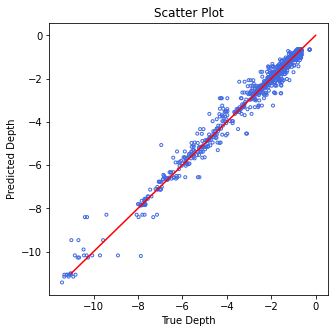

In [34]:
def scatter_plotter(x, y, plot_color='royalblue', line_color='r', title='Scatter Plot'):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(x, y, marker='.', color=plot_color, facecolors='none')
    min_val, max_val = round(np.nanmin(x)), round(np.nanmax(x))
    ax.plot([min_val, max_val], [min_val, max_val], color=line_color)
    ax.set_xlabel('True Depth')
    ax.set_ylabel('Predicted Depth')
    ax.set_title(title)

    return fig, ax

fig, ax = scatter_plotter(
    x=test_data['z'],
    y=test_data['z_validate']
)

fig.savefig(scatter_plot_loc)